### Treść zadania

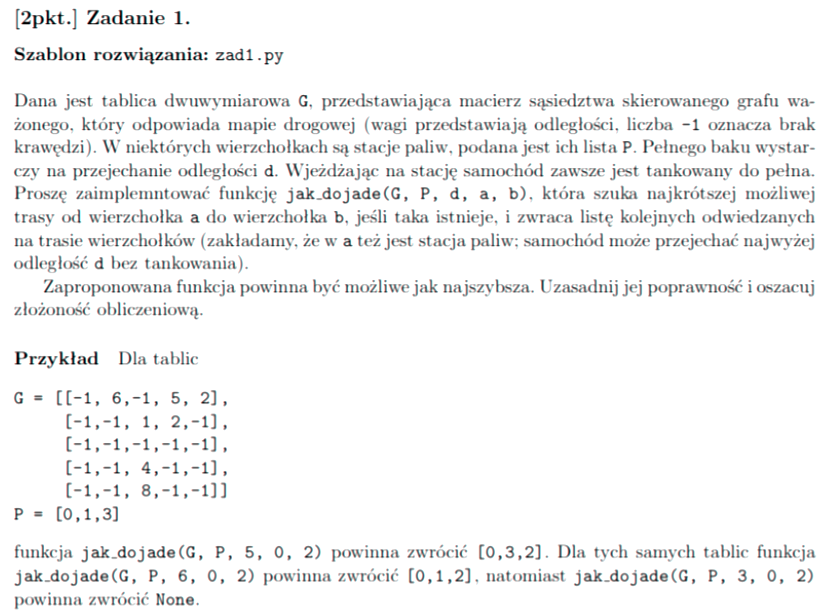

# Sposób I
### (Gorszy, bo otrzymujemy graf w postaci macierzowej i konwertujemy go na reprezentację listową)*
\* Za takie podejście są odejmowane punkty na kolokwium i egzaminie. Konieczne jest więc użycie algorytmu Dijkstry dostosowanego do reprezentacji macierzowej grafu (zaprezentowany w sposobie drugim).

### Omówienie algorytmu

Algorytm opiera się na podobnej zasadzie do poprzedniego i polega na zapamiętywaniu dla każdego z wierzchołków dodatkowych informacji. W tym przypadku dla każdego z wierzchołków tworzymy tablicę o rozmiarze równym $ d + 1 $ i będziemy spamiętywać, jaka jest najkrótsza ścieżka, dla której dojedziemy do danego wierzchołka z daną ilością paliwa.
<br><br>
Na wstępie warto sobie jeszcze utworzyć nowy graf, ktory zawiera jedynie krawędzie o wagach nie większych niż $ d $, który będzie reprezentowany przez listy sąsiedztwa. Ułatwi to nam przetrwarzanie grafu, przy pomocy zmodyfikowanej wersji algorytmu Dijkstry.
<br><br>
Sumaryczne wagi (długości) najkrótszych ścieżek będziemy spamiętywać w tablicy o wymiarach $ V \times d $, gdzie: <br>
$ weights[u][f] $ - długość najkrótszej ścieżki z wierzchołka startowegod do $ u $, przy pozostałej ilości paliwa równej $ f $ (przed dojechaniem do tego wierzchołka, więc jeżeli w danym mieście tankujemy, to dopiero będzie miało to wplyw na kolejno odwiedzone wierzchołki)
###### UWAGA
Choć nie jest powiedziane to w zadaniu, musimy założyć, że wszystkie wielkości w zadaniu są wyrażone liczbami naturalnymi.

### Złożoność

###### Obliczeniowa:
$ O(V^2 + (E \cdot d) \cdot log(d \cdot V)) $ <br>
$ V^2 $ bo musimy przejrzeć całą macierz o wymiarach $ V \times V $, <br>
$ (d \cdot E) \cdot log(d \cdot V) $ - bo potencjalnie w najgorszym przypadku możemy do każdego wierzchołka dotrzeć z różną ilością paliwa w zbiorniku.
###### Pamięciowa:
$ O(d \cdot V + E) $, gdzie $ E $ - liczba krawędzi w nowym grafie (bo tworzymy graf w postaci list sąsiedztwa)

### Implementacja

In [1]:
from queue import PriorityQueue


def create_graph(G: 'graph represented by adjacency matrix', d: 'capacity of a fuel tank'):
    n = len(G)
    G2 = [[] for _ in range(n)]

    for u in range(n):
        for v in range(n):
            if G[u][v] == -1 or G[u][v] > d:
                continue
            G2[u].append((v, G[u][v]))
    
    return G2


def dijkstra(G: 'graph represented by adjacency lists', 
             S: 'array of fuel stations indices',
             d: 'capacity of a fuel tank',
             s: 'source', 
             t: 'target'):
    n = len(G)
    inf = float('inf')
    weights = [[inf] * (d + 1) for _ in range(n)]
    parents = [[None] * (d + 1) for _ in range(n)]
    is_station = [False] * n
    for i in S: is_station[i] = True
    pq = PriorityQueue()
    pq.put((0, d, d, s, None))

    end_fuel = None
    
    while not pq.empty():
        min_w, fuel, prev_fuel, u, parent = pq.get()
        # We will find the minimum total weight path only once so the
        # code below this if statement will be executed only once
        if min_w < weights[u][fuel]:
            weights[u][fuel] = min_w
            parents[u][fuel] = parent, prev_fuel
            # Break a loop if we found a shortest path to the specified
            # target
            if u == t: 
                end_fuel = fuel
                break
            # Add all the neighbours of the u vertex to the priority queue
            # (only if the current amount of fuel is enough to reach them)
            # (also update teh current amoutn of fuel)
            if is_station[u]: fuel = d
                
            for v, weight in G[u]:
                if fuel >= weight and weights[v][fuel - weight] == inf:
                    pq.put((min_w + weight, fuel - weight, fuel, v, u))
                
    return (end_fuel, parents, weights) if end_fuel is not None else (None,) * 3


def get_path(parents, fuel, s, t):
    path = [t]
    
    entry = parents[t][fuel]
    while entry:
        t, fuel = entry
        path.append(t)
        entry = parents[t][fuel]
        
    path.append(s)
        
    path.reverse()
    return path


def jak_dojade(G: 'graph represented by adjacency matrix',
               P: 'array of fuel stations indices',
               d: 'capacity of a fuel tank',
               a: 'start city',
               b: 'end city'):
    G2 = create_graph(G, d)
    fuel, parents, weights = dijkstra(G2, P, d, a, b)
    if fuel is None: return None
    return get_path(parents, fuel, a, b)

###### Kilka testów

In [2]:
G = [[-1,  6, -1,  5,  2],
     [-1, -1,  1,  2, -1],
     [-1, -1, -1, -1, -1],
     [-1, -1,  4, -1, -1],
     [-1, -1,  8, -1, -1]]

P = [0,1,3]

print(jak_dojade(G, P, 5, 0, 2))
print(jak_dojade(G, P, 6, 0, 2))
print(jak_dojade(G, P, 3, 0, 2))

[0, 3, 2]
[0, 1, 2]
None


# Sposób II

### Omówienie algorytmu

Sama idea pozostaje taka sama jak poprzednio. Tym razem jednak korzystamy z odpowiedniego dla grafu w reprezentacji macierzowej algorytmu Dijkstry.

### Złożoność

###### Obliczeniowa:
$ O(V^2) $
###### Pamięciowa:
$ O(d \cdot V) $ - uznaję, że graf w postaci macierzy jest dany i nie wliczam go do złożoności. Taka złożoność wynika z konieczności rozważenia każdego wierzchołka w taki sposób, jakby w jego miejscu było $ d $ różnych wierzchołków.

### Implementacja

In [3]:
class Node:
    def __init__(self, vert=None, idx=None):
        self.vert = vert
        self.idx  = idx
        self.next = None


def vertices_to_process_ll(n: 'number of vertices', 
                           reps: "number of each vertex's repetitions"):
    head = Node()
    tail = head
    for u in range(n):
        for i in range(reps): 
            tail.next = Node(u, i)
            tail = tail.next
    return head


def get_min_weight_vertices(head, weights):
    if not head.next: return []  # If no more vertices are remaining
    
    # Find all vertices with the lowest distance paths
    res = []
    min_w = float('inf')
    prev = head
    
    while prev.next:
        if weights[prev.next.vert][prev.next.idx] < min_w:
            min_w = weights[prev.next.vert][prev.next.idx]
            res = [prev]
        elif weights[prev.next.vert][prev.next.idx] == min_w:
            res.append(prev)
        prev = prev.next
        
    # Remove nodes found and store vertex-index pairs
    for i in range(len(res) - 1, -1, -1):
        prev = res[i]
        res[i] = prev.next.vert, prev.next.idx
        prev.next = prev.next.next
    
    return res


def dijkstra_dp(G: 'graph represented by adjacency matrix', 
                P: 'array of fuel stations indices',
                capacity: 'capacity of fuel tank', 
                s: 'start vertex',
                t: 'target vertex'):
    n = len(G)
    inf = float('inf')
    # Store information about vertices which haven't been processed yet
    step = capacity + 1
    to_process = vertices_to_process_ll(n, step)
    parents    = [[None] * step for _ in range(n)]
    weights    = [[inf] * step for _ in range(n)]
    weights[s][capacity] = 0  # Car starts on a vertex where is a station
    is_station = [False] * n
    for s_idx in P: 
        is_station[s_idx] = True
    
    found_res = False
    res_fuel = -inf
    
    # Loop till there are some vertices which haven't been processed yet
    while not found_res:
        # Find a vertex of the minimum total weight path
        vert = get_min_weight_vertices(to_process, weights)
        # Loop over all the vertices with shortest paths
        for u, fuel in vert:
            # If we reached the target, we must have found the shortest path
            # (or exhausted all shortest paths vertices and there is no path)
            if u == t:
                # If there is no path (the shortest path has a length infinity)
                if weights[u][fuel] == inf: return (None,) * 3
                res_fuel = fuel
                found_res = True
            # Refuel if u vertex is a station
            curr_fuel = capacity if is_station[u] else fuel
            # Iterate over the vertex's neighbours and update weights of the paths
            for v in range(n):
                dist = G[u][v]
                # Skip if no edge (-1 means not edge) or if a vertex is too far
                if dist == -1 or dist > curr_fuel: continue
                # Update path's weight if found a shorter one
                new_fuel = curr_fuel - dist
                if weights[u][fuel] + dist < weights[v][new_fuel]:
                    weights[v][new_fuel] = weights[u][fuel] + dist
                    parents[v][new_fuel] = u, fuel
                
    return res_fuel, weights, parents


def get_path(parents, t, res_fuel):
    path = [t]
    fuel = res_fuel
    
    entry = parents[t][fuel]
    while entry:
        t, fuel = entry
        path.append(t)
        entry = parents[t][fuel]
        
    path.reverse()
    return path


def jak_dojade(G: 'graph represented by adjacency matrix',
               P: 'array of fuel stations indices',
               d: 'capacity of a fuel tank',
               a: 'start city',
               b: 'end city'):
    res_fuel, _, parents = dijkstra_dp(G, P, d, a, b)
    if not parents: return None
    return get_path(parents, b, res_fuel)

###### Kilka testów

In [4]:
G = [[-1,  6, -1,  5,  2],
     [-1, -1,  1,  2, -1],
     [-1, -1, -1, -1, -1],
     [-1, -1,  4, -1, -1],
     [-1, -1,  8, -1, -1]]

P = [0,1,3]

print(jak_dojade(G, P, 5, 0, 2))
print(jak_dojade(G, P, 6, 0, 2))
print(jak_dojade(G, P, 3, 0, 2))

[0, 3, 2]
[0, 1, 2]
None
